In [1]:
import pandas as pd
pd.options.display.max_columns = 999
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import textblob
import os

In [2]:
#Viz
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background') #If use jupyter dark theme
import matplotlib_venn

In [3]:
DATA_PATH = 'E://Kaggle//Avito//'
DATA_IMAGE_PATH = DATA_PATH + 'images//'

# Train
* Misc
    * item_id - Ad id.
    * user_id - User id.
    * region - Ad region.
    * city - Ad city.
    * parent_category_name - Top level ad category as classified by Avito's ad model.
    * category_name - Fine grain ad category as classified by Avito's ad model.
    * price - Ad price.
    * item_seq_number - Ad sequential number for user.
    * activation_date- Date ad was placed.
    * user_type - User type.
* Image    
    * image - Id code of image. Ties to a jpg file in train_jpg. Not every ad has an image.
    * image_top_1 - Avito's classification code for the image.
* Text        
    * param_1 - Optional parameter from Avito's ad model.
    * param_2 - Optional parameter from Avito's ad model.
    * param_3 - Optional parameter from Avito's ad model.
    * title - Ad title.
    * description - Ad description.
* Target
    * deal_probability - The target variable. This is the likelihood that an ad actually sold something.

In [4]:
train = pd.read_csv(DATA_PATH+'train.csv')
test = pd.read_csv(DATA_PATH+'test.csv')

In [5]:
train.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


Common categories/values between train and test sets

In [6]:
for col in test.columns:
    test_set = set(test[col].unique())
    train_set = set(train[col].unique())
    diffset = test_set - train_set 
    print('For',col,'test set has',str(1-len(diffset)/len(test_set)),'in common with train')

For item_id test set has 0.0 in common with train
For user_id test set has 0.22194015075032103 in common with train
For region test set has 1.0 in common with train
For city test set has 0.9884428223844283 in common with train
For parent_category_name test set has 1.0 in common with train
For category_name test set has 1.0 in common with train
For param_1 test set has 1.0 in common with train
For param_2 test set has 0.9765625 in common with train
For param_3 test set has 0.9414784394250514 in common with train
For title test set has 0.21545166907686575 in common with train
For description test set has 0.017186408331255176 in common with train
For price test set has 0.5994239385534457 in common with train
For item_seq_number test set has 0.6403398363750787 in common with train
For activation_date test set has 0.0 in common with train
For user_type test set has 1.0 in common with train
For image test set has 2.146705879835231e-06 in common with train
For image_top_1 test set has 0.99934

### Missing values (more on it in their individual EDA)

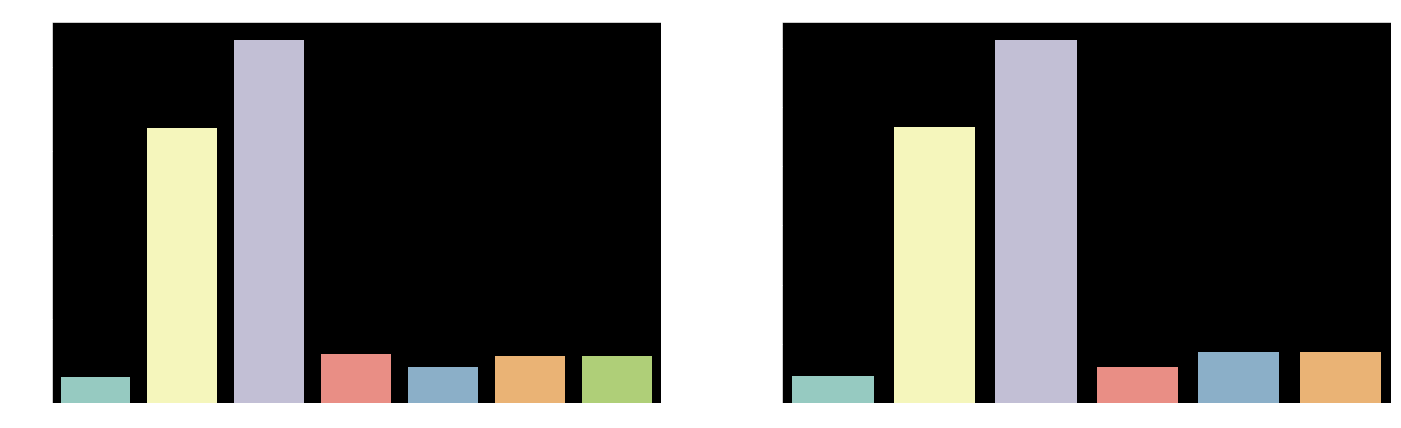

In [7]:
fig, ax = plt.subplots(figsize=(24,7),ncols=2,nrows=1)

temp = train.isnull().sum()
missings = [x for x,y in zip(temp,train.columns) if x > 0]
columns = [y for x,y in zip(temp,train.columns) if x > 0]
sns.barplot(x=columns,y=missings,ax=ax[0])
ax[0].set_title('Train set missings')

temp = test.isnull().sum()
missings = [x for x,y in zip(temp,test.columns) if x > 0]
columns = [y for x,y in zip(temp,test.columns) if x > 0]
sns.barplot(x=columns,y=missings,ax=ax[1])
ax[1].set_title('Test set missings')

plt.show()

Its interesting to see that description is never empty in the test set.

### Activation date

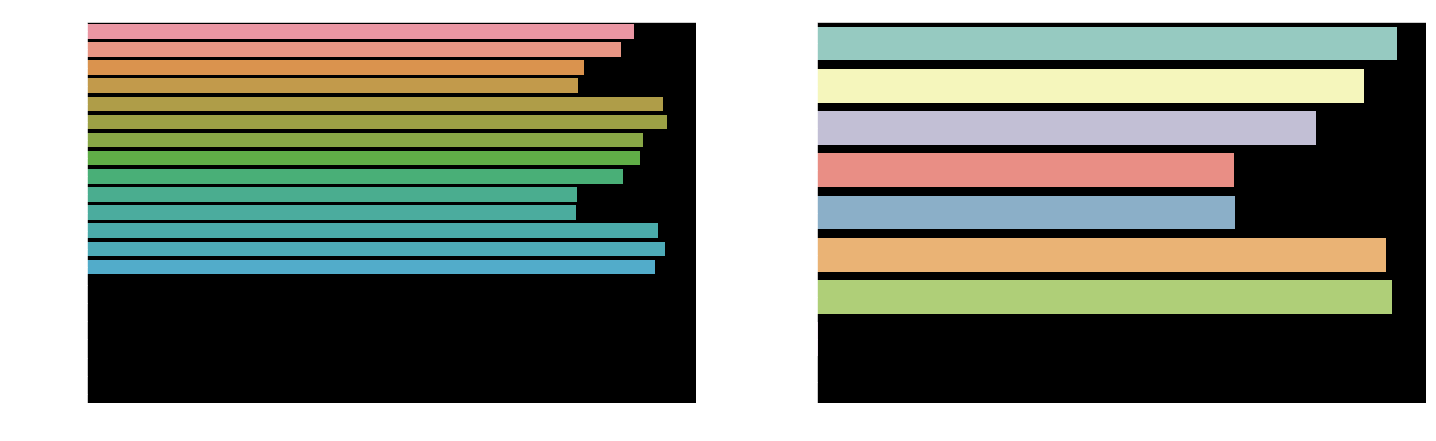

In [8]:
fig, ax = plt.subplots(figsize=(24,7),ncols=2,nrows=1)
sns.countplot(y='activation_date',data=train.sort_values('activation_date'),ax=ax[0])
ax[0].set_title('Train set')
sns.countplot(y='activation_date',data=test.sort_values('activation_date'),ax=ax[1])
ax[1].set_title('Test set')
plt.show()

There are some residuals for extra days in both data sets. Train is mostly 2 weeks and test 1 week.

On a per day basis there are a bit more ads in the train set than in test set. 

Something is weird though. The lowest 2 days in train are systematically Friday/Saturday while for test set it is Saturday/Sunday. This is verified below. I currently am not sure about how this information can be used. Maybe it's just randomness in the daily count (hard to verify variability with so little days). Maybe it suggests a validation set should be weighted more like the test set.

In [9]:
train['activation_date']=pd.to_datetime(train['activation_date'])
train['activation_day']=train['activation_date'].dt.weekday
test['activation_date']=pd.to_datetime(test['activation_date'])
test['activation_day']=test['activation_date'].dt.weekday

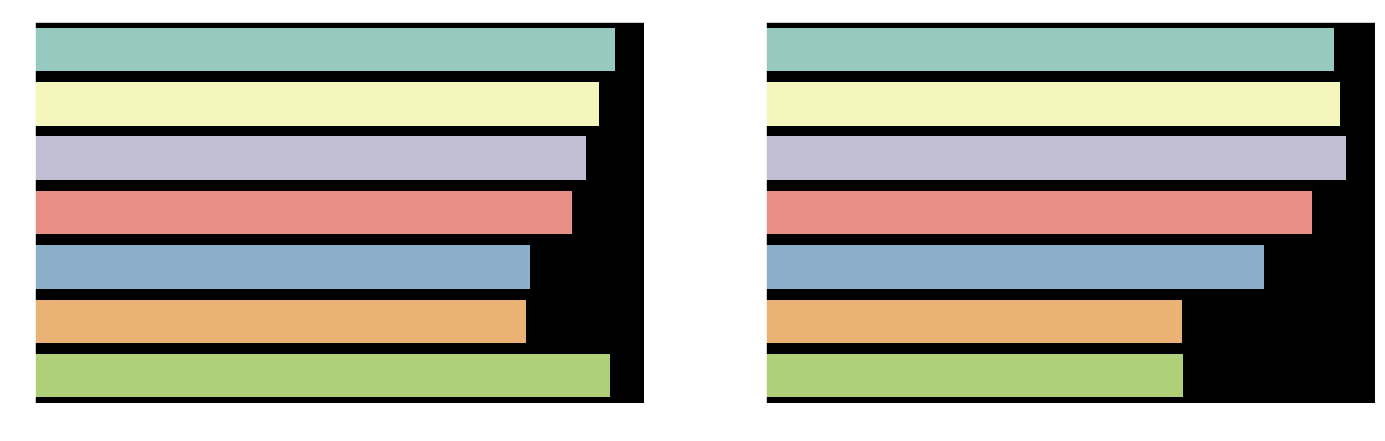

In [10]:
fig, ax = plt.subplots(figsize=(24,7),ncols=2,nrows=1)
sns.countplot(y='activation_day',data=train.sort_values('activation_day'),ax=ax[0])
ax[0].set_title('Train set')
sns.countplot(y='activation_day',data=test.sort_values('activation_day'),ax=ax[1])
ax[1].set_title('Test set')
plt.show()

### Analysing user_id
* How many user_id are in both train and test
* Are there some prominent users (difference between train and test)

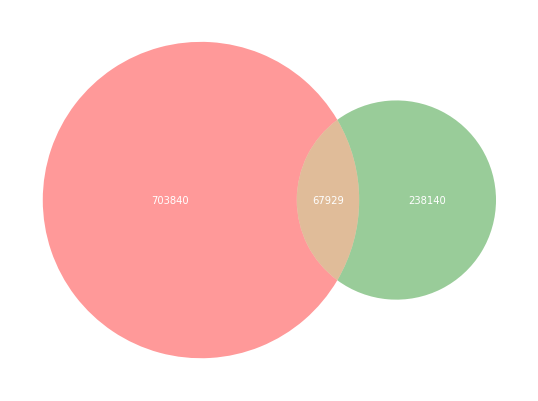

In [11]:
users_trainset = set(train['user_id'])
users_testset = set(test['user_id'])

plt.figure(figsize=(12,7))
matplotlib_venn.venn2([users_trainset,users_testset],set_labels=('Train user ids','Test user ids'))
plt.show()

Some users are common in both but most are new users

In [12]:
user_counts = train.groupby(['user_id'],as_index=False).agg({'item_id':'count','deal_probability':'mean'}).rename(
    columns={'item_id':'count_train'})
user_counts_test = test.groupby(['user_id'],as_index=False)['item_id'].count().rename(columns={'item_id':'count_test'})
user_counts = user_counts.merge(user_counts_test,how='outer',on=['user_id'])

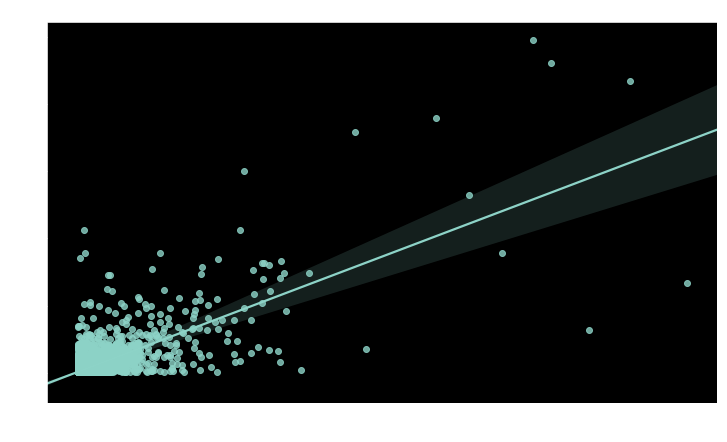

In [13]:
plt.figure(figsize=(12,7))
sns.regplot(user_counts['count_train'],user_counts['count_test'])
plt.title('Train vs Test user item counts')
plt.show()

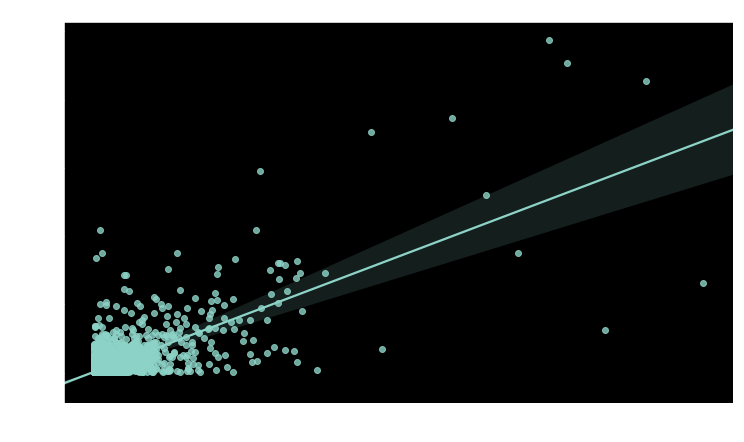

In [14]:
user_counts['relative_count_train']=user_counts['count_train']/user_counts['count_train'].sum()
user_counts['relative_count_test']=user_counts['count_test']/user_counts['count_test'].sum()

plt.figure(figsize=(12,7))
sns.regplot(user_counts['relative_count_train'],user_counts['relative_count_test'])
plt.title('Train vs Test relative user item counts')
plt.show()

Overall there is some correlation, but it is weak (the reg line is mostly driven by outliers). Also since both graphs have the same shape it means that test and train are fairly balanced in terms of what proportion prominent users take in the data set.

Let's see if there is a link between deal probability and number of items.

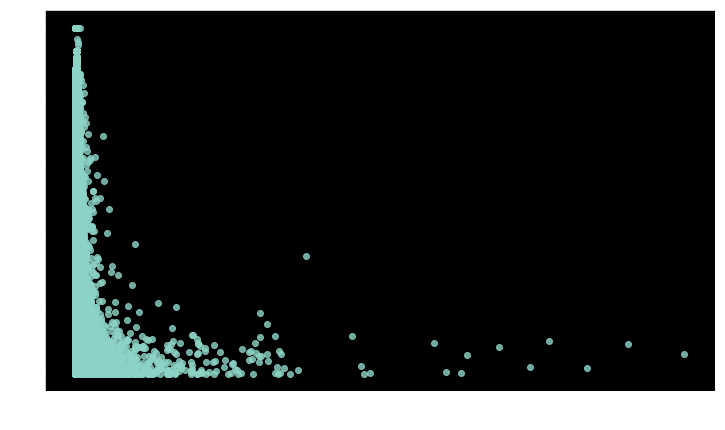

In [15]:
temp = user_counts[user_counts['count_train']>=0]
plt.figure(figsize=(12,7))
sns.regplot(temp['count_train'],temp['deal_probability'],fit_reg=False)
plt.show()
del temp

Nothing interesting. It just shows that the more items for a user, deal probability converges to around 0.10. All should be captured by using user_id. If the user is known the model will be able to use it.

Possible features :
* Use the relative_count to put user into a bin depending on size in the dataset.

### Analysing Region
* See region split
* See if similar between train and test

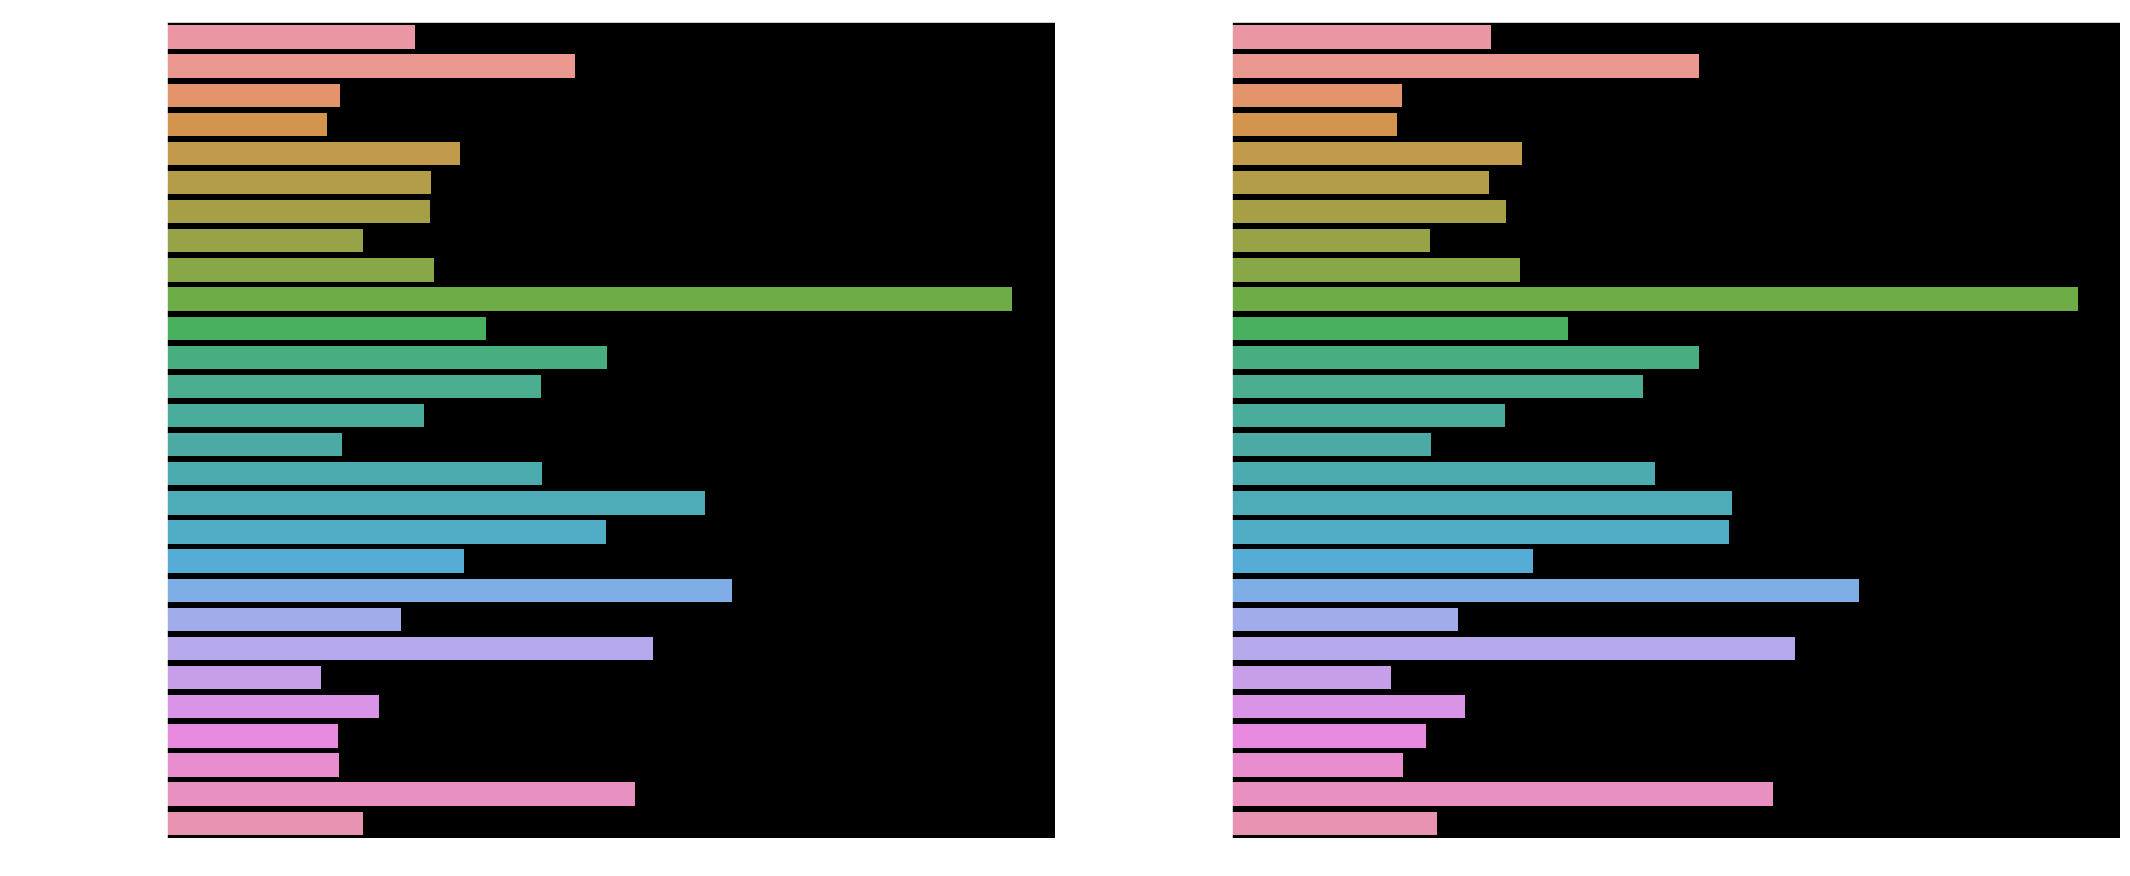

In [16]:
fig, ax = plt.subplots(figsize=(35,15), ncols=2, nrows=1)
sns.countplot(y='region',data=train.sort_values('region'), ax=ax[0])
ax[0].set_title("Train set")
sns.countplot(y='region',data=test.sort_values('region'), ax=ax[1])
ax[1].set_title("Test set")
plt.show()

Pretty good split between regions and very similar split between train and test.

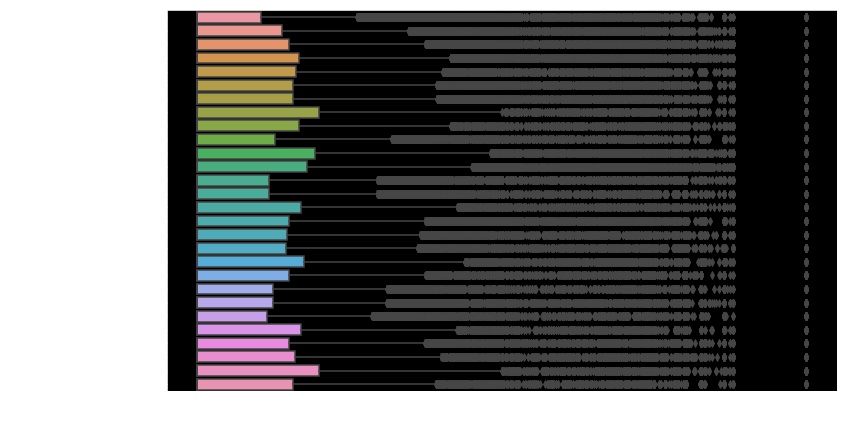

In [17]:
plt.figure(figsize=(12,7))
sns.boxplot(x='deal_probability',y='region',data=train)
plt.show()

Similar distributions of deal probability per regions

### Analysing City
* See if similar cities
* See if there are some very different cities in term of probabilities

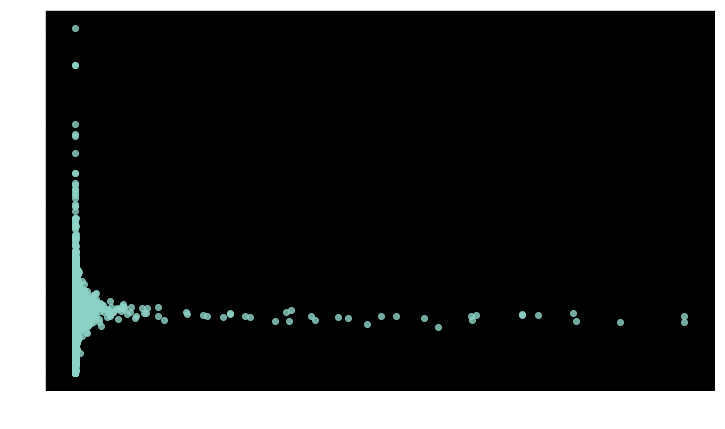

In [18]:
plt.figure(figsize=(12,7))
sns.regplot(x='count',y='deal_probability',
            data=train.groupby(['city']).agg({'item_id':'count','deal_probability':'mean'}).rename(columns={'item_id':'count'}),fit_reg=False)
plt.show()

This shape is pretty common and actually means that all cities converge to a similar deal probability the more item there are (around 0.15).
It shows some very popular and many small cities.

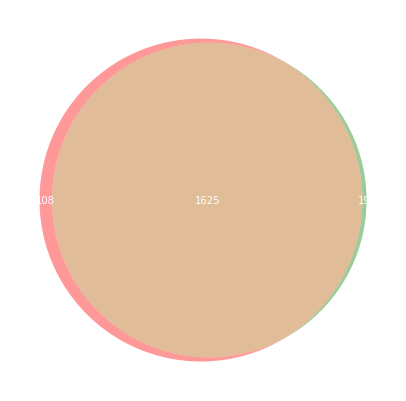

In [19]:
trainset = set(train['city'])
testset = set(test['city'])

plt.figure(figsize=(12,7))
matplotlib_venn.venn2([trainset,testset],set_labels=('Train cities','Test cities'))
plt.show()

The overlap is not perfect. Some cities are not in the train set. I'm not an expert on Russia but those 19 are likely to be very small cities. Feature idea:
* Use the count to put city into a bin depending on number of items.

### Analysing Parent Category
First let's make the translation.

In [20]:
def translate(text,to='EN'):
    try:
        return textblob.TextBlob(text).translate(to='EN').raw
    except:
        return text

In [21]:
def translate_column(data,col_name): 
    russian_names = pd.Series(data[col_name].unique())
    english_names = russian_names.apply(translate)
    english_df = pd.DataFrame({col_name:russian_names,'EN_'+col_name:english_names})
    return data.merge(english_df)

In [22]:
train = translate_column(train,'parent_category_name')
test = translate_column(test,'parent_category_name')

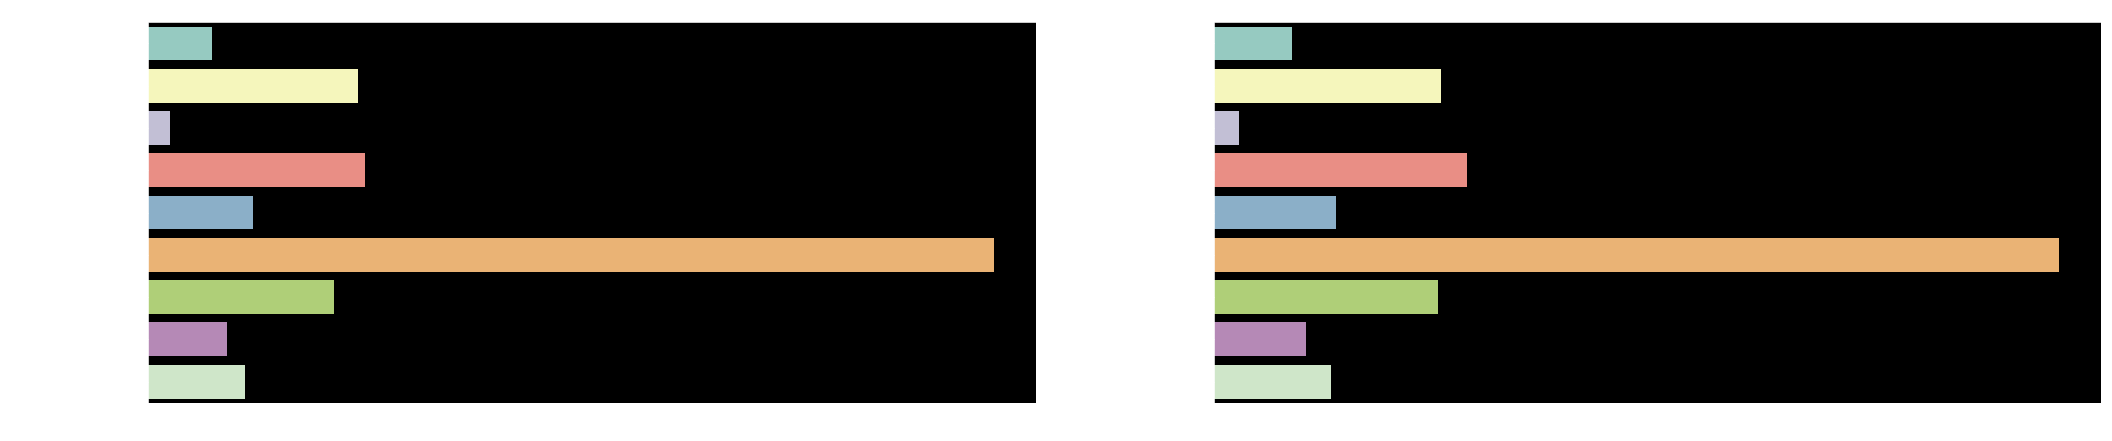

In [23]:
fig, ax = plt.subplots(figsize=(35,7), ncols=2, nrows=1)
sns.countplot(y='EN_parent_category_name',data=train.sort_values('EN_parent_category_name'), ax=ax[0])
ax[0].set_title("Train set")
sns.countplot(y='EN_parent_category_name',data=test.sort_values('EN_parent_category_name'), ax=ax[1])
ax[1].set_title("Test set")
plt.show()

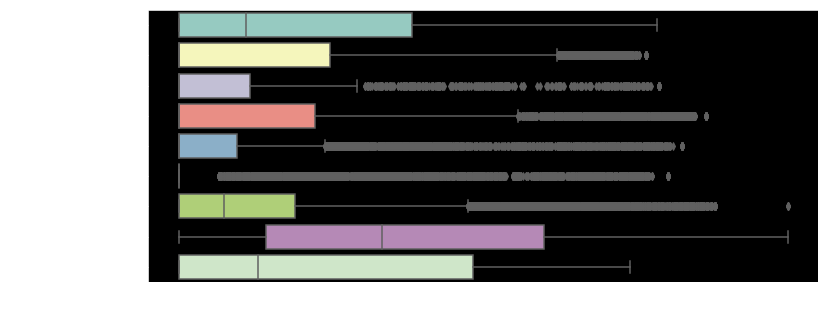

In [24]:
plt.figure(figsize=(12,5))
sns.boxplot(x='deal_probability',y='EN_parent_category_name',data=train.sort_values('EN_parent_category_name'))
plt.show()

There are a lot of variability here with Avito dealing with the different categories in very different ways. Services is higher than others and only Property and services can be a 1.0. It is a very good candidate to use some form of statistic encoding on the categorical variable. Feature idea:
* mean / std / min / max encoding of parent category (make sure to use a CV scheme to avoid leakage)

### Analysing category name

In [25]:
train = translate_column(train,'category_name')
test = translate_column(test,'category_name')

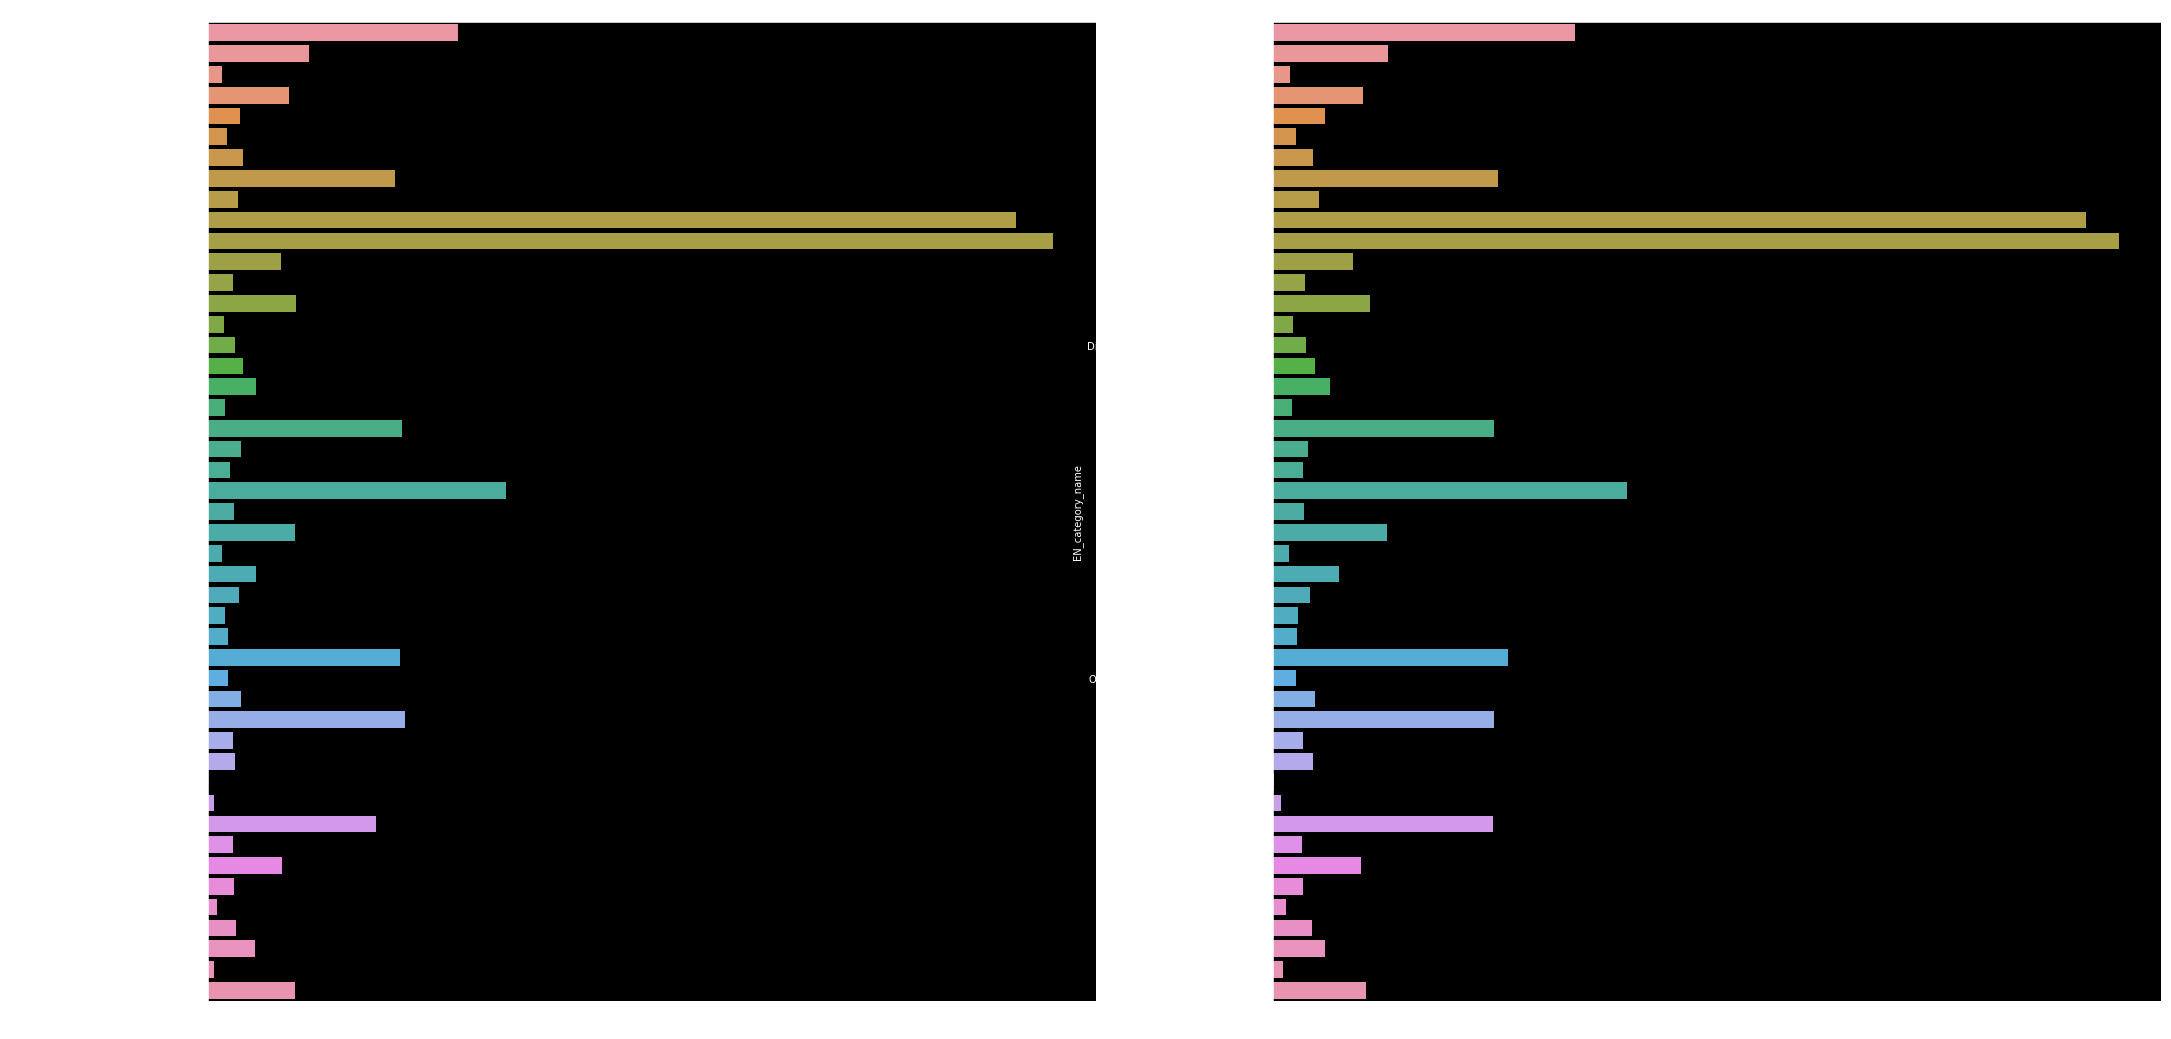

In [26]:
fig, ax = plt.subplots(figsize=(35,18), ncols=2, nrows=1)
sns.countplot(y='EN_category_name',data=train.sort_values('EN_category_name'), ax=ax[0])
ax[0].set_title("Train set")
sns.countplot(y='EN_category_name',data=test.sort_values('EN_category_name'), ax=ax[1])
ax[1].set_title("Test set")
plt.show()

Clothes are the most common. We also have a pretty similar test and train distribution here.

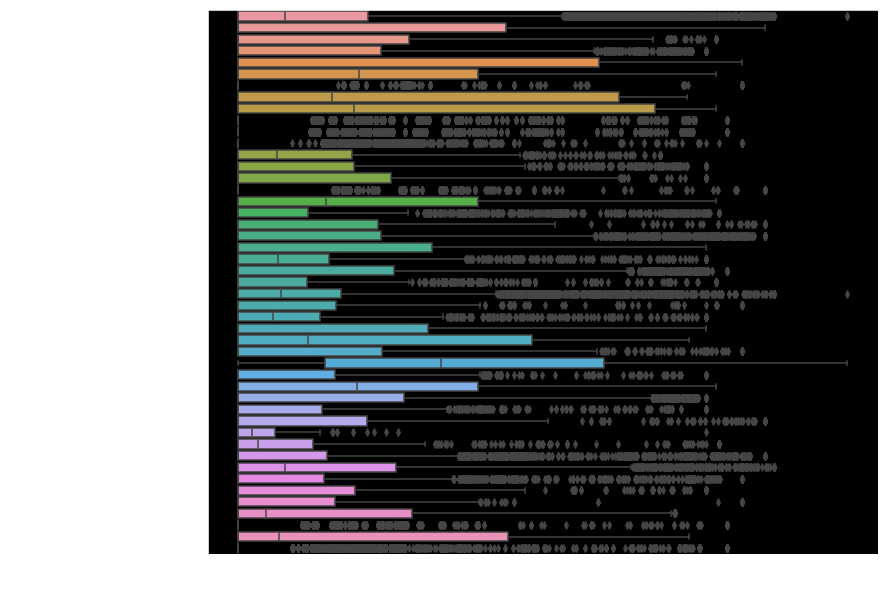

In [27]:
plt.figure(figsize=(12,10))
sns.boxplot(x='deal_probability',y='EN_category_name',data=train.sort_values('EN_category_name'))
plt.show()

Like for the parent category, it varies a lot from one category to the next. It's as a result also a good candidate for encoding. Feature idea:
* mean / std / min / max encoding of category (make sure to use a CV scheme to avoid leakage)

### Analysing Price
Let's first look at missing values.

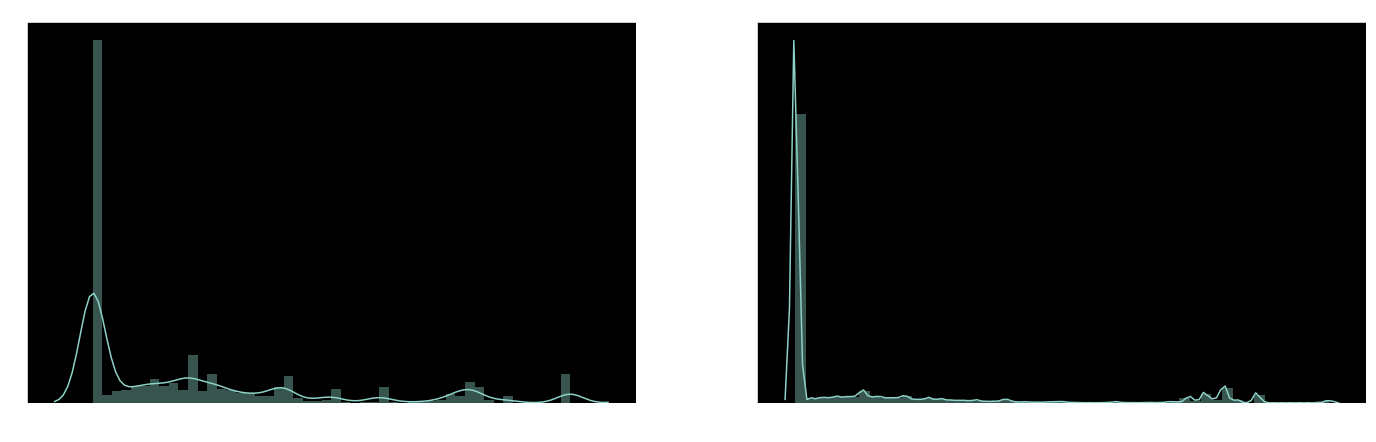

In [28]:
fig, ax = plt.subplots(figsize=(24,7), ncols=2, nrows=1)
sns.distplot(train[train['price'].isna()]['deal_probability'], ax=ax[0])
ax[0].set_title("Missing prices")
sns.distplot(train[train['price'].notnull()]['deal_probability'], ax=ax[1])
ax[1].set_title("Others")
plt.show()

The distribution of deal probability in missing prices is a lot different than for the other. It's interesting to see a peak of 1 for missing prices. I also looked at missing prices across categories but did not find anything of interest.

Let's look at the price distribution itself.

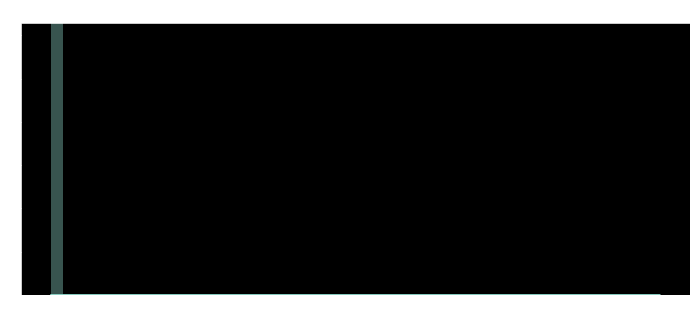

In [29]:
plt.figure(figsize=(12,5))
sns.distplot(train[train['price'].notnull()]['price'])
plt.title('Price Distribution')
plt.show()

It looks heavily skewed... let's log it.

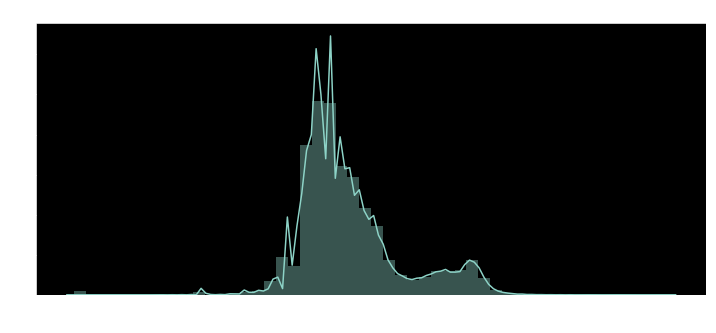

In [30]:
plt.figure(figsize=(12,5))
sns.distplot(np.log(0.001+train[train['price'].notnull()]['price']))
plt.title('Log Price Distribution')
plt.show()

A forum idea suggested to look at deal vs price range

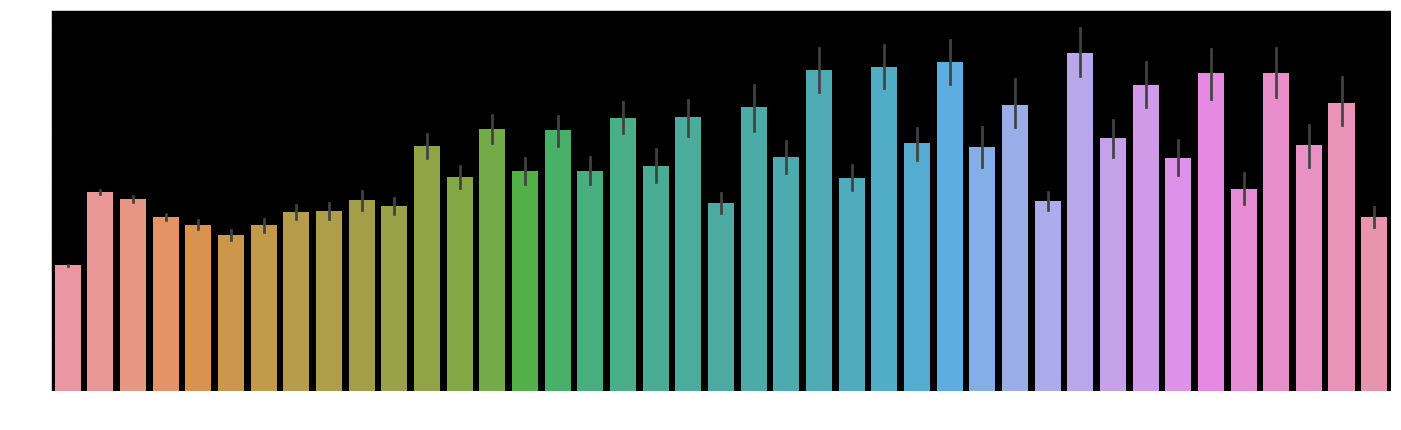

In [46]:
plt.figure(figsize=(24,7))
temp = train[train.price <= 200000].copy()
temp['price_range']=temp['price'].fillna(0).astype(int)
temp['price_range']=temp['price_range']//5000*5000
sns.barplot(x='price_range',y='deal_probability',data=temp)
plt.show()

This is a round down to nearest 5000. This may suggest some price range to be unattractive. For example 55000-60000 has higher probability than 50000-55000. A possibility is that users are unattracted about prices that just started a new 10K. Let's also verify how it looks for lower prices.

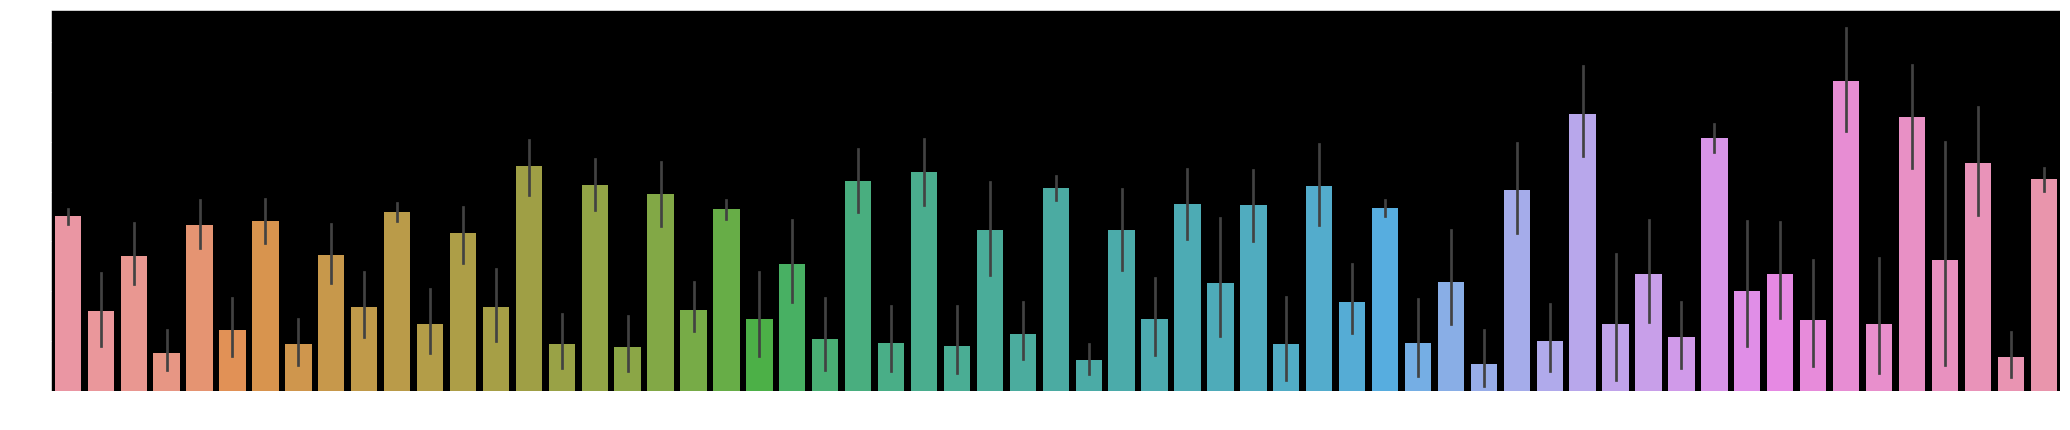

In [57]:
plt.figure(figsize=(36,7))
temp = train[train.price.between(30000,60000)].copy() #this is visible up to 50000
temp['price_range']=temp['price'].fillna(0).astype(int)
temp['price_range']=temp['price_range']//500*500
sns.barplot(x='price_range',y='deal_probability',data=temp)
plt.show()

This actually suggests the reverse. That actually round prices are more attractive. It peaks every 1000 and not in between.

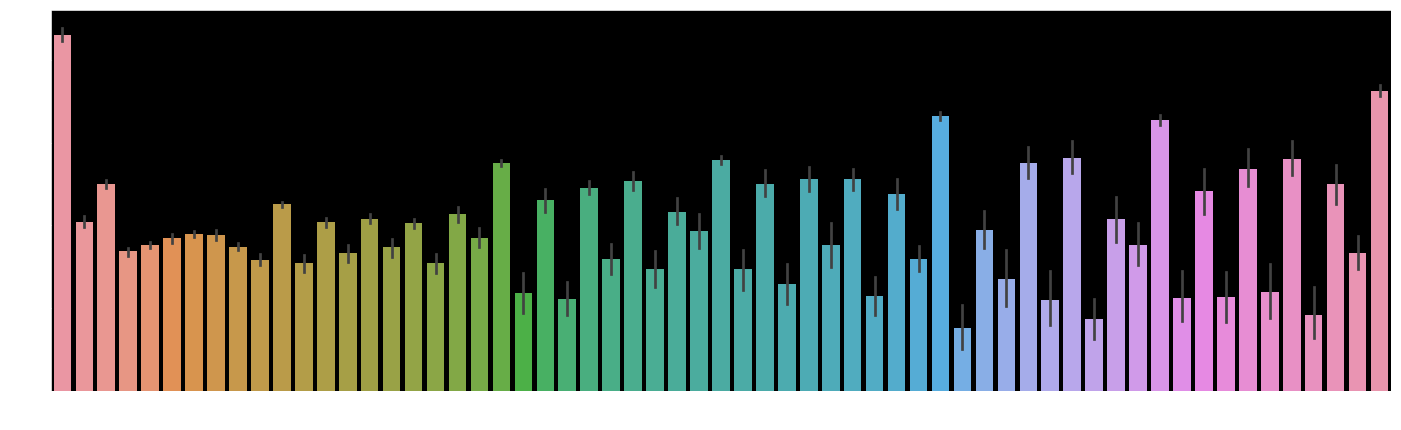

In [58]:
plt.figure(figsize=(24,7))
temp = train[train.price <= 3000].copy()
temp['price_range']=temp['price'].fillna(0).astype(int)
temp['price_range']=temp['price_range']//50*50
sns.barplot(x='price_range',y='deal_probability',data=temp)
plt.show()

Price ends up being a pretty important feature. With Image top. Comparing price asked with average price based on region/image etc can be a good idea. Maybe a nearest neighbour approach is good. Let's verify it varies:

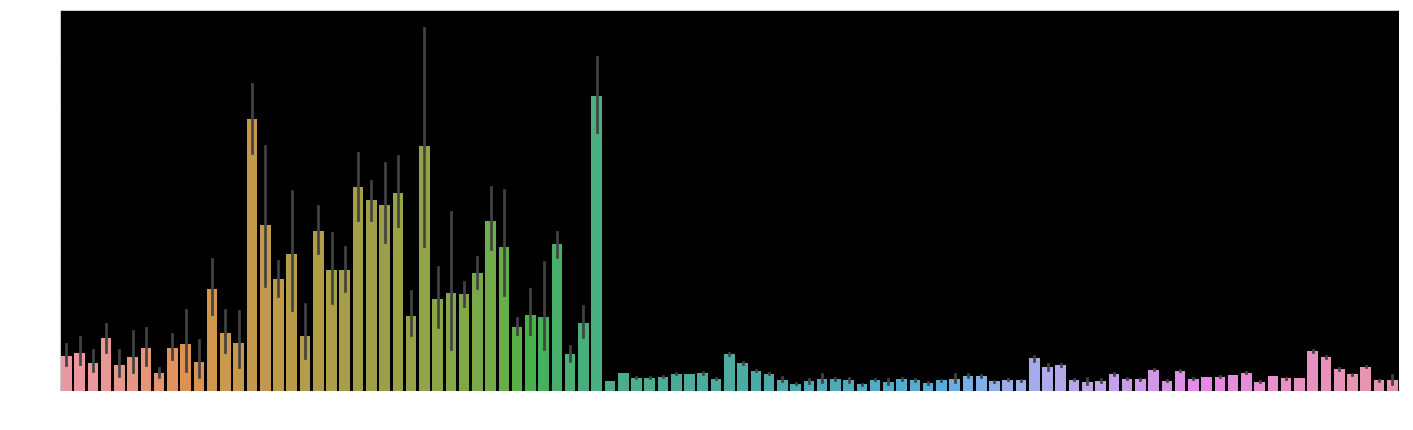

In [76]:
plt.figure(figsize=(24,7))
temp = train[(train.image_top_1 <= 100)&(train.price<100000)].copy()
sns.barplot(x='image_top_1',y='price',data=temp)
plt.show()

Features
* Log price
* Multiple behavior of prices depending on the order (somewhat dealt also with log)
* Below 2000 whether or not you start a new hundred
* Below 50000 whether or not you start a new 1K
* For the rest whether or not you start a new 10K
* Whether you are at the start of a 10K or at the end
* An easy way is to capture all digits of the price as features
* Distance compared to mean price of class, region, item_region etc.

### Analysing item_seq_number

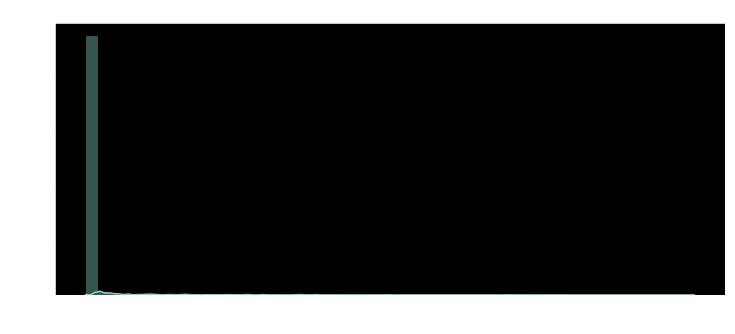

In [31]:
plt.figure(figsize=(12,5))
sns.distplot(train['item_seq_number'])
plt.title('Item Seq Distribution')
plt.show()

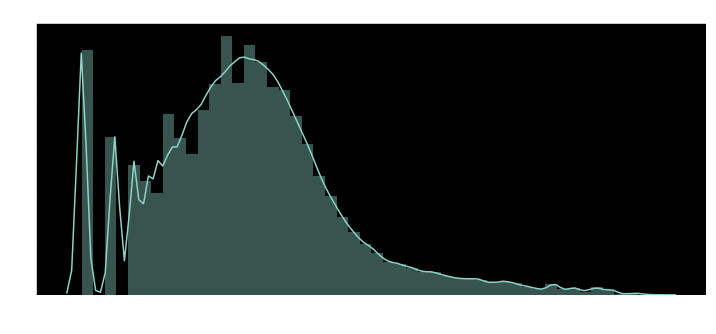

In [32]:
plt.figure(figsize=(12,5))
sns.distplot(np.log(train['item_seq_number']))
plt.title('Log Item Seq Distribution')
plt.show()

The definition of this variable is vague. On the forum Peter hurford makes the following hypothesis:

*I agree it is vague and clarification on this variable, and many other variables (including the target!) would be helpful. 
From looking at the variable, my best guess is that an item_seq_number of X means that is the Xth ad the user posted.
I infer this because: (a) item_seq_number is higher as time is higher and (b) mean item_seq_number is much higher for user_types I expect post more -- "Company" (mean 646.2) and "Shop" (mean 10633) is much higher than for "Private" user_type (35.3).*

Verifying the split per user_type:

In [33]:
print('Train set')
print(train.groupby(['user_type'])['item_seq_number'].mean())
print('Test set')
print(test.groupby(['user_type'])['item_seq_number'].mean())

Train set
user_type
Company      646.206961
Private       35.316218
Shop       10633.569834
Name: item_seq_number, dtype: float64
Test set
user_type
Company     870.732928
Private      36.890621
Shop       9985.729375
Name: item_seq_number, dtype: float64


Suggestion is to use it as numerical or ordinal. A good feature to try is also a log on that variable. Feature:
* item_seq_number as numerical
* log item_seq_number

### Analysing User Type

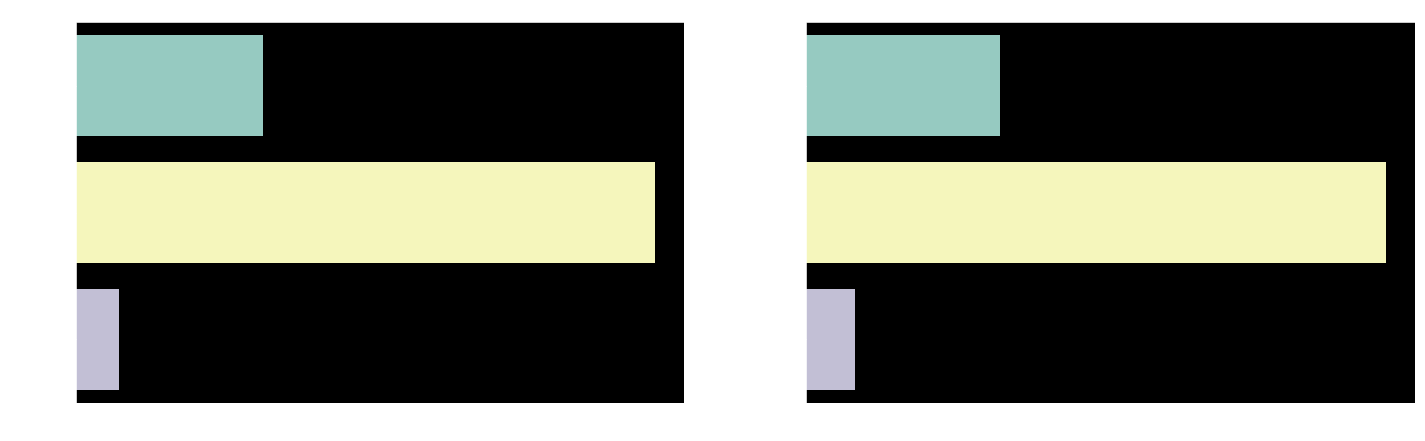

In [34]:
fig, ax = plt.subplots(figsize=(24,7),ncols=2,nrows=1)
sns.countplot(y='user_type',data=train.sort_values('user_type'),ax=ax[0])
ax[0].set_title('Train set')
sns.countplot(y='user_type',data=test.sort_values('user_type'),ax=ax[1])
ax[1].set_title('Test set')
plt.show()

Nothing really interesting here. Private is the most common user but also the smallest average as seen before. Similar splits between the two sets.

### Analysing image_top_1 (and image)
First let's look at missing values relative to the deal probability

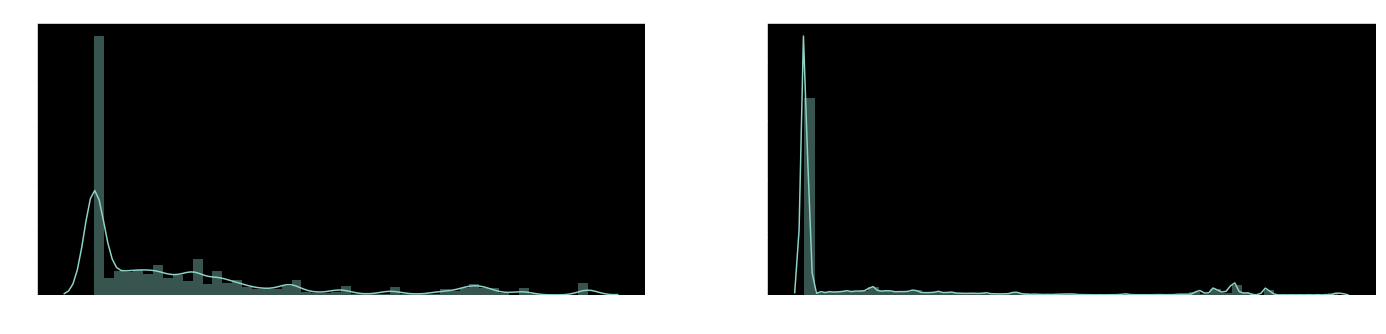

In [35]:
fig, ax = plt.subplots(figsize=(24,5),nrows=1,ncols=2)
sns.distplot(train[train['image_top_1'].isnull()]['deal_probability'],ax=ax[0])
ax[0].set_title('Missing image_top_1')
sns.distplot(train[train['image_top_1'].notnull()]['deal_probability'],ax=ax[1])
ax[1].set_title('Others image_top_1')
plt.show()

Interestingly it is fairly similar to how missing prices behave.

Now the description of the variable is not very clear and discussions on the forum don't really help. The best would probably to pull up some of the images and see if we can find what it really means. So far I have only downloaded the first part of the image data (which should already be a lot with 250K images). Below we can see that the image_top value has not much to do with quality but probably more with content.

In [36]:
image_list = os.listdir(DATA_IMAGE_PATH)

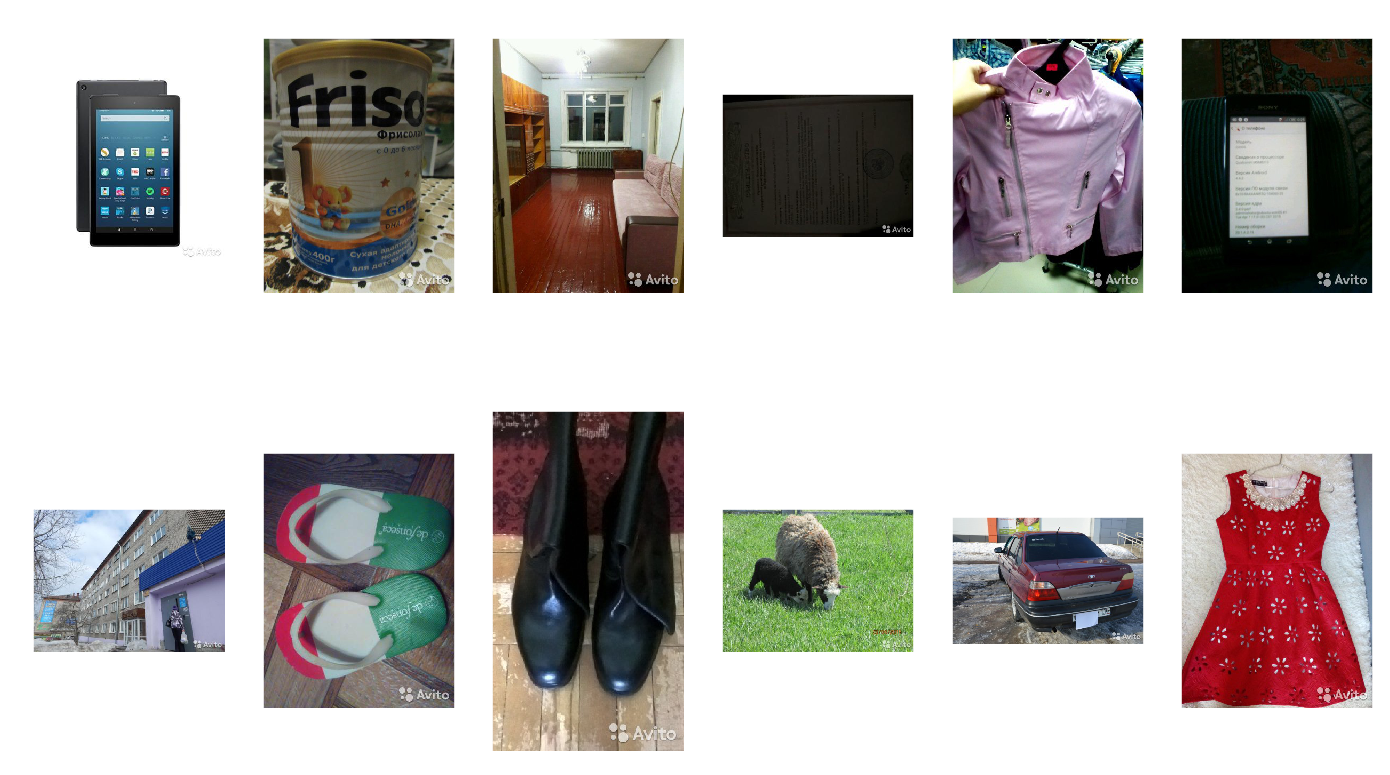

In [37]:
nrows = 2
ncols = 6
fig, ax = plt.subplots(figsize=(24,14),nrows=nrows,ncols=ncols)
for i in range(nrows):
    for j in range(ncols):
        img = plt.imread(DATA_IMAGE_PATH+image_list[i*ncols+j])
        ax[i][j].imshow(img)
        ax[i][j].set_title(train[train['image']==image_list[i*ncols+j][:-4]]['image_top_1']) #Find the image_top of the image (slow... I use a better method later)
plt.show()

We can view how the image_top are related to category name (a nice compact proxy to content) below (it is similar for test set)

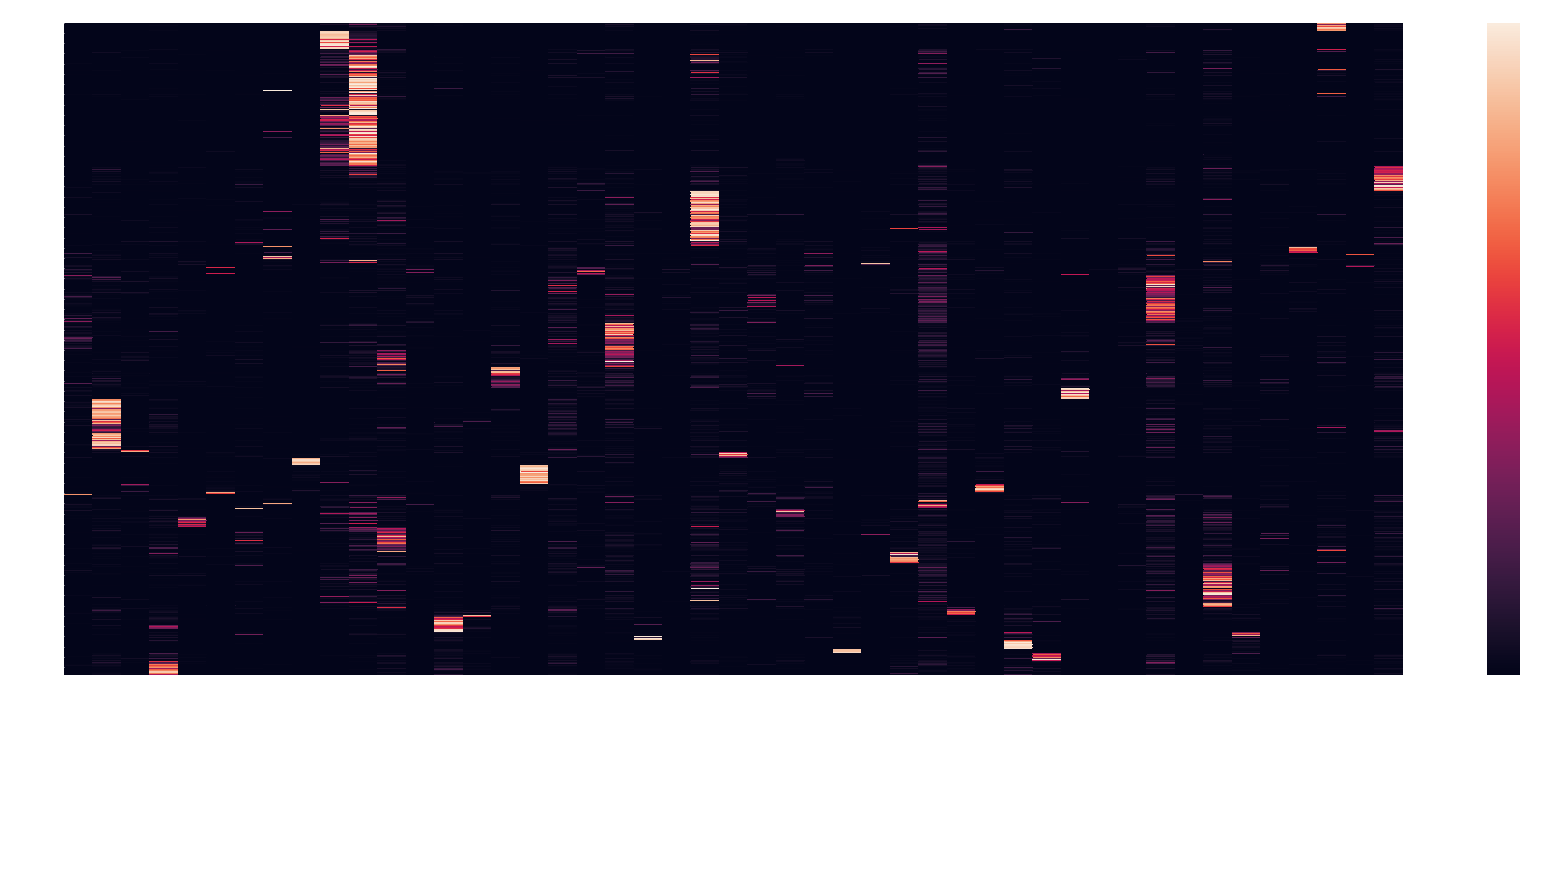

In [38]:
plt.figure(figsize=(30,12))
heatmatrix = pd.crosstab(train['image_top_1'],train['EN_category_name'])
rows = heatmatrix.index
columns = heatmatrix.columns
heatmatrix = heatmatrix.values / np.sum(heatmatrix.values,axis=1,keepdims=True) #Normalize
heatmatrix = pd.DataFrame(heatmatrix,index=rows,columns=columns)
sns.matrix.heatmap(heatmatrix)
plt.title('Train Image_top_1 vs Category_name crosstab')
plt.show()

Is image_top_1 same from train and test ?

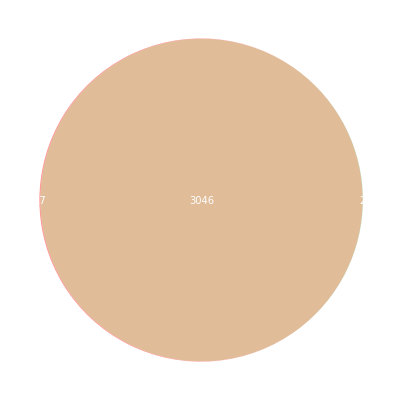

In [39]:
trainset = set(train['image_top_1'].unique())
testset = set(test['image_top_1'].unique())

plt.figure(figsize=(12,7))
matplotlib_venn.venn2([trainset,testset],set_labels=('Train image tops','Test image tops'))
plt.show()

In [40]:
testset-trainset

{nan, 614.0}

In [41]:
len(test[test['image_top_1']==614.0])

1

As it has only one record it's not very important. We can simply infer a close one anyway.

In [42]:
temp = pd.DataFrame(image_list, columns=['image_file'])
temp['image']=[x[:-4] for x in temp['image_file']]
train_imagepack1 = pd.merge(train,temp)

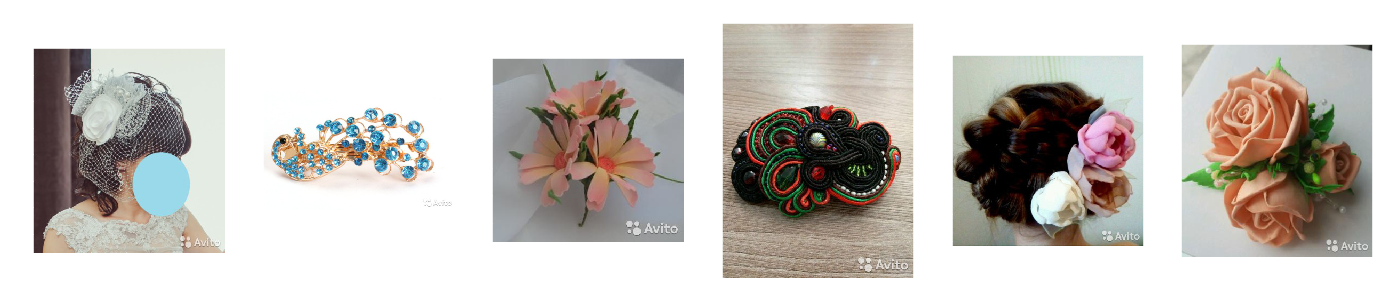

In [43]:
image_class = 10 #What kind of image to show
n=6 #Number of images to show (in a single row)

fig, ax = plt.subplots(figsize=(24,7),ncols=n)
i=0
temp = train_imagepack1[train_imagepack1['image_top_1']==image_class].reset_index(drop=True)
for idx,image in enumerate(temp['image_file'][:n]):
    img = plt.imread(DATA_IMAGE_PATH+image)
    ax[i].imshow(img)
    ax[i].set_title(temp.loc[idx,'EN_category_name'])
    i+=1
plt.show()

All of these categories make sense and this image class clearly is about head flower accessory. I will even argue that "top 1" can simply be the top class of an image classification algorithm. I've tested a few others. Now let's see for class 10 what the image look like when it belongs in a totally different category.

In [44]:
category_counts = temp.groupby(['EN_category_name'])['item_id'].count()
print(category_counts)

EN_category_name
Children's clothing and footwear     4
Clothes, shoes, accessories          9
Furniture and interior               3
Offer of services                    1
Phones                               1
Watches & Jewelry                   12
beauty and health                    1
Name: item_id, dtype: int64


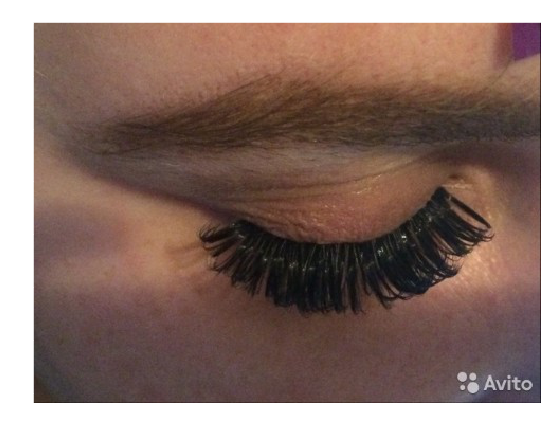

In [45]:
temp2=temp[temp['EN_category_name']=='Offer of services'].reset_index(drop=True) #That part is inputted manually but can use category_counts.idxmin()
i=0
n_wrong=min(n,len(temp2))
fig, ax = plt.subplots(figsize=(24,7),ncols=n_wrong)
for idx,image in enumerate(temp2['image_file'][:n]):
    img = plt.imread(DATA_IMAGE_PATH+image)
    if n_wrong>1:
        ax[i].imshow(img)
        ax[i].set_title(temp2.loc[idx,'EN_category_name'])
    else:
        plt.imshow(img)
        plt.title(temp2.loc[idx,'EN_category_name'])
    i+=1
plt.show()

What appears is that some images are apparently poorly classified and there is a mismatch between the classified and the category. This example is likely more an Offer of services than an accessory.

This can probably be exploited. If an item is in a class and a category that usually don't go together this could be used as a feature. 

Potential features:
* Use the Category vs Image_top heatmap as a feature. The created variable will have a high number if category is usually associated with that class, and low otherwise. Need to normalize.
    * This can be viewed as a measure of image quality
* Since AVITO is probably classifying the images we could actually try to reverse engineer that model and get the top 1 top 2 top 3 top 4 top 5 instead of only top 1.
    * Using top 5 probability can also give some measure of image quality: high probability probably mean clear distinguishable object
* Some additional stats on category and class relationships (number of classes, average value in normalize matrix etc)

## Text variables
### Looking at param_1 param_2 param_3
Let's start with the missings distribution as usual

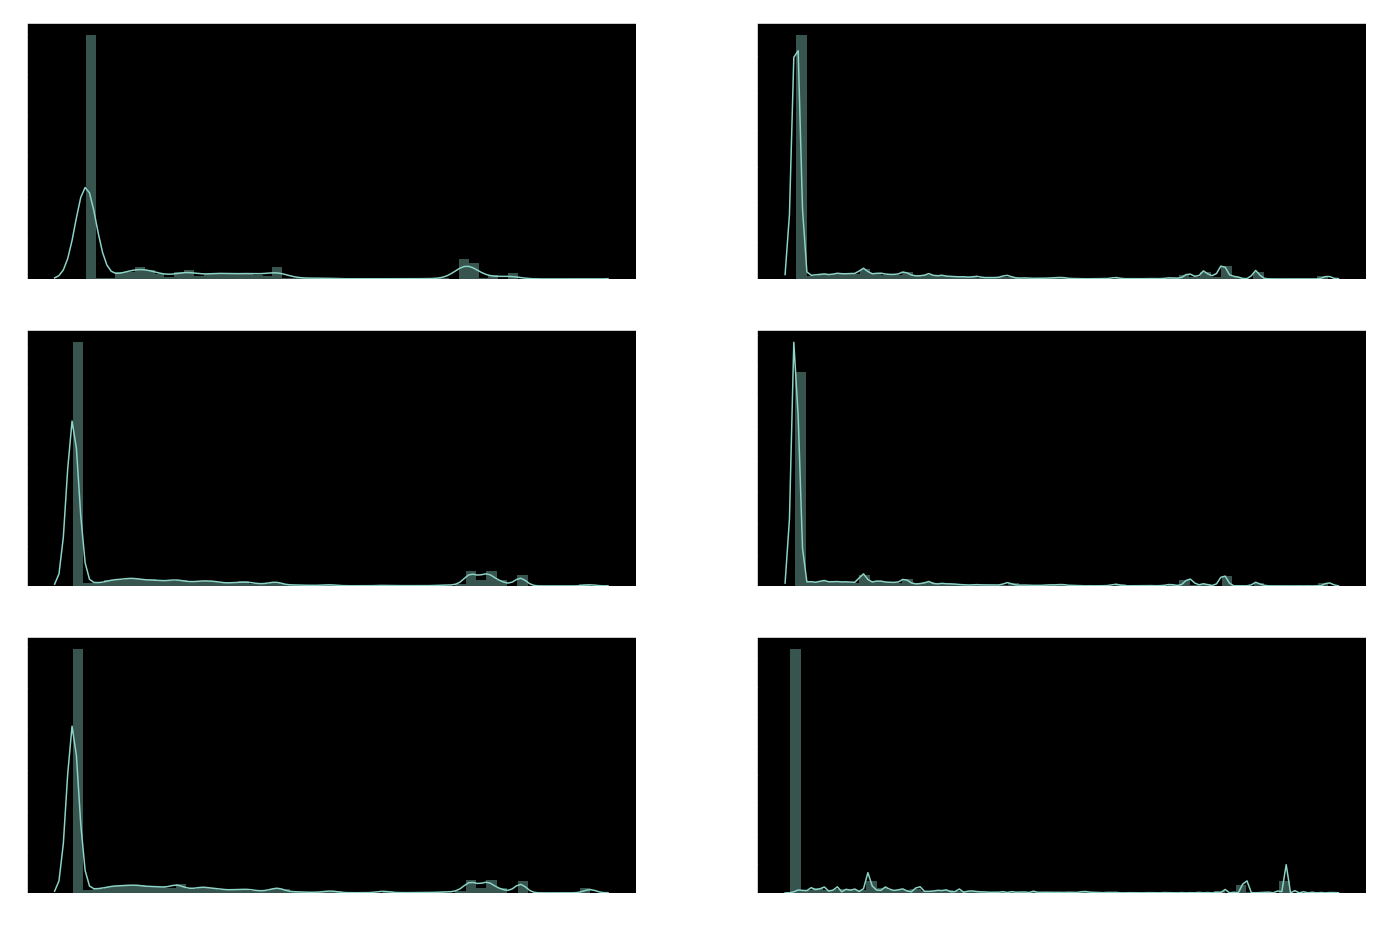

In [46]:
fig, ax = plt.subplots(figsize=(24,16),nrows=3,ncols=2)
sns.distplot(train[train['param_1'].isnull()]['deal_probability'],ax=ax[0][0])
ax[0][0].set_title('Missings param_1')
sns.distplot(train[train['param_1'].notnull()]['deal_probability'],ax=ax[0][1])
ax[0][1].set_title('Others')
sns.distplot(train[train['param_2'].isnull()]['deal_probability'],ax=ax[1][0])
ax[1][0].set_title('Missings param_2')
sns.distplot(train[train['param_2'].notnull()]['deal_probability'],ax=ax[1][1])
ax[1][1].set_title('Others')
sns.distplot(train[train['param_3'].isnull()]['deal_probability'],ax=ax[2][0])
ax[2][0].set_title('Missings param_3')
sns.distplot(train[train['param_3'].notnull()]['deal_probability'],ax=ax[2][1])
ax[2][1].set_title('Others')
plt.show()

These ones are actually more similar between the two distribution and contrary to image_seq and price there isn't a peak at 1.0 for the missings.

In [47]:
#This will take a few minutes
train = translate_column(train,'param_1')
test = translate_column(test,'param_1')
train = translate_column(train,'param_2')
test = translate_column(test,'param_2')
train = translate_column(train,'param_3')
test = translate_column(test,'param_3')

In [48]:
print(train['EN_param_1'].unique()[:10])
print(train['EN_param_2'].unique()[:10])
print(train['EN_param_3'].unique()[:10])

['Bed dress' 'Car seats' 'Goods for school' 'Toys' 'Baby carriages'
 "Children's furniture" 'Bicycles and scooters' 'Feeding products'
 'Goods for bathing' nan]
[nan 'Other' 'Spare parts' 'Covers and films' 'Charging device'
 'Headsets and earphones' 'Accumulators' 'Modems and Routers'
 'Cables and adapters' 'Styluses']
[nan '26' 'Without size' '28' '25' '27' '29' '> 34' '32' '31']


This looks like mostly some additional categories that a user can put his ad. With the first being a bit more general and the next ones more and more specific. The last one seems to have a lot information on clothes size.

Let's see what kind of overlap exists with the train set.

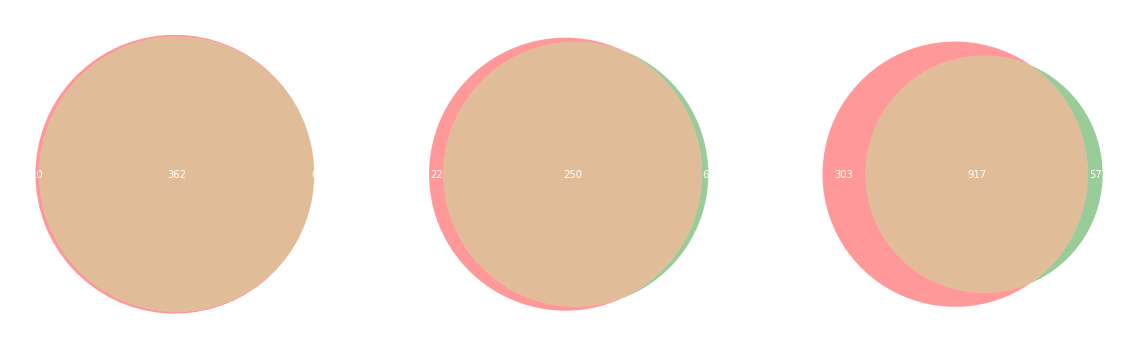

In [49]:
fig, ax = plt.subplots(figsize=(20,7),nrows=1,ncols=3)
trainset = set(train['param_1'])
testset = set(test['param_1'])
ax[0] = matplotlib_venn.venn2((trainset,testset),set_labels=('Train param1', 'Test param1'),ax=ax[0])
trainset = set(train['param_2'])
testset = set(test['param_2'])
ax[1] = matplotlib_venn.venn2((trainset,testset),set_labels=('Train param2', 'Test param2'),ax=ax[1])
trainset = set(train['param_3'])
testset = set(test['param_3'])
ax[2] = matplotlib_venn.venn2((trainset,testset),set_labels=('Train param3', 'Test param3'),ax=ax[2])
plt.show()

For the most part train and test have similar domain between test and train.

In [50]:
trainset = set(train['param_2'])
testset = set(test['param_2'])
print(testset-trainset)
trainset = set(train['param_3'])
testset = set(test['param_3'])
print(testset-trainset)

{'Alpina', 'СМЗ', 'Talbot', 'GAC', 'Wartburg', 'Shuanghuan'}
{'Atrai', 'CL', 'Rodius', 'Porte', '3000 GT', 'Tagora', 'Biante', 'Gratour', 'Cayman', 'RS Q3', 'Retona', 'RS7', 'Ypsilon', '353', 'GLE-класс AMG', 'Clio RS', 'View CS2', 'MR-S', 'Life', 'GTO', 'S6', 'Cooper S Clubman', 'G90', 'R8', 'WAY M1', 'Caprice', 'Saratoga', 'С-3Д', 'Corsica', 'Ace', 'Impala', 'Move', 'Magnum', 'Fuego', 'Cronos', 'Princip', 'ATS', 'XK', 'GLC-класс AMG', 'MAX', '146', 'Stealth', 'B5', 'M25', 'Tercel', 'H230', '110', 'Эстония', 'Quest', 'Sambar', 'Celsior', 'Reno', '2335', 'Mustang', 'Sceo', '8', '240'}


So it is mostly Brands that are different between the two datasets. Maybe a good proxy would help. Feature idea :
* Treat Params as categories
* For never seen Params see if images can be leveraged to find something resembling (maybe some kind of KNN on images embeddings)

### Looking at Title

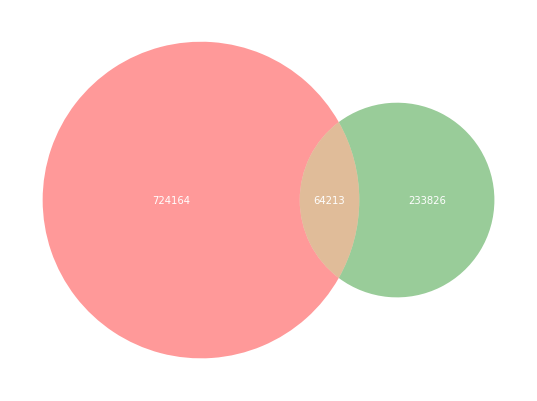

In [81]:
plt.figure(figsize=(12,7))
trainset = set(train['title'])
testset = set(test['title'])
matplotlib_venn.venn2((trainset,testset),set_labels=('Train Titles', 'Test Titles'))
plt.show()

In [51]:
wordVect = CountVectorizer()
title_sparse = wordVect.fit_transform(train['title'])
print(len(wordVect.vocabulary_))

206935


In [52]:
word_counts = title_sparse.sum(axis=1)

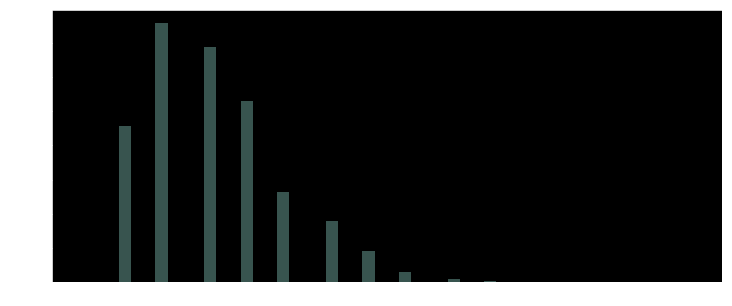

In [53]:
plt.figure(figsize=(12,5))
sns.distplot(word_counts,kde=False)
plt.show()

Most titles are between 1 and 6 words long. A first idea for feature is the title length.

Let's now look at the example given on the overview tab of the competition where many '!' could decrease your chances:

In [54]:
charVect = CountVectorizer(analyzer='char',lowercase=False,max_df=0.05)
title_char_sparse = charVect.fit_transform(train['title'])
char_counts = title_char_sparse.sum(axis=1)

In [55]:
idx = charVect.vocabulary_['!']
train['!']=title_char_sparse[:,idx].toarray()

In [56]:
print(train.groupby(['!']).agg({'deal_probability':'mean','item_id':'count'}))

    deal_probability  item_id
!                            
0           0.139059  1494905
1           0.147221     5803
2           0.149495      661
3           0.157281     1572
4           0.191132      281
5           0.217498       79
6           0.186044       66
7           0.160394       21
8           0.043729        8
9           0.264745       10
10          0.195950        6
11          0.099135        4
12          0.235073        3
13          0.063430        2
15          0.000000        1
16          0.000000        1
19          0.068490        1


Doesn't seem true that the number of ! would make your ad less good. However the example also assumed caps so a good feature could be to count uppercase letters

In [57]:
train['number_uppercase'] = train['title'].str.split(expand=True).stack().str.isupper().reset_index().groupby(
    ['level_0']).sum()[0]

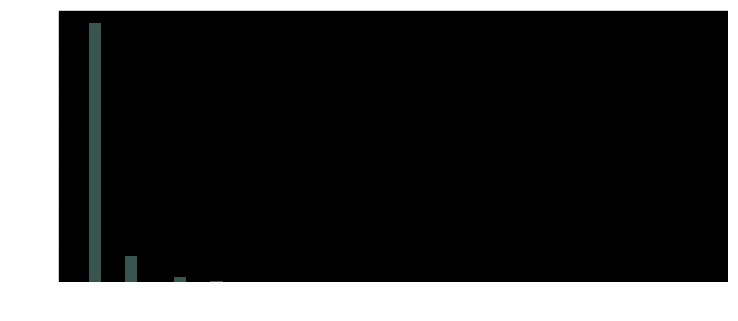

In [58]:
plt.figure(figsize=(12,5))
sns.distplot(train['number_uppercase'],kde=False)
plt.show()

In [59]:
print(train.groupby(['number_uppercase']).agg({'deal_probability':'mean','item_id':'count'}))

                  deal_probability  item_id
number_uppercase                           
0.0                       0.134712  1337245
1.0                       0.183032   135244
2.0                       0.136836    25513
3.0                       0.146729     4119
4.0                       0.140654      945
5.0                       0.136009      259
6.0                       0.107434       72
7.0                       0.181375       13
8.0                       0.174654        5
9.0                       0.000000        2
10.0                      0.000000        2
11.0                      0.166670        1
12.0                      0.500000        2
13.0                      0.000000        1
14.0                      0.000000        1


This can be a worthy feature to add.

Let's now analyse with TFIDF how much components of a SVD we could use.

In [60]:
wordVect = TfidfVectorizer(min_df=2,max_df=0.2,ngram_range=(1,3)) #Remove some of the words that are in more 20% of ads. Also remove words and ngrams that are very rare
title_sparse = wordVect.fit_transform(train['title'])

In [61]:
print(len(wordVect.vocabulary_))

446690


In [62]:
n_components = 50
svd = TruncatedSVD(n_components=n_components)
title_sparse_proj  = svd.fit_transform(title_sparse)

I did not find an easy way to compute variance explained with sklearn sparse matrixs so I had to calculate it myself as follow:
$$\frac{Var_i(X_{proj})}{Var_{Total}(X)}$$
With $Var(X)$ being calculated as $E(X^2) - E(X)^2$

In [63]:
def explained_variance(projection,original):
    
    var_proj = (np.multiply(projection,projection).mean(axis=0)-np.multiply(projection.mean(axis=0),projection.mean(axis=0)))

    original_squared = original.copy()
    original_squared.data = original_squared.data**2
    var_orig = (original_squared.mean(axis=0)-np.multiply(original.mean(axis=0),original.mean(axis=0)))

    explained_var = var_proj / var_orig.sum()
    
    return explained_var

In [64]:
explained_var = explained_variance(title_sparse_proj,title_sparse)

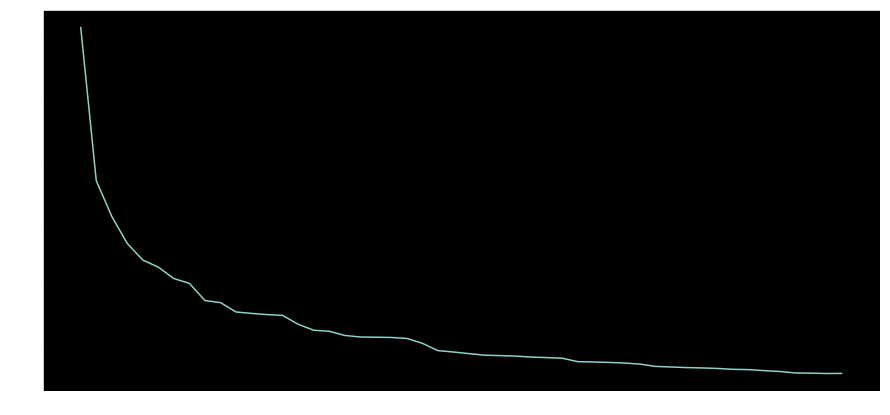

In [65]:
plt.figure(figsize=(15,7))
pd.Series(explained_var).plot()
plt.xticks(range(1,n_components))
plt.show()

Using at least 7 components seems reasonable.

In [66]:
charVect = TfidfVectorizer(min_df=2,max_df=0.2,ngram_range=(1,1),analyzer='char') #Remove some of the words that are in more 20% of ads. Also remove words and ngrams that are very rare
title_char_sparse = charVect.fit_transform(train['title'])

In [67]:
print(len(charVect.vocabulary_))

73


In [68]:
n_components = 50
svd_char = TruncatedSVD(n_components=n_components)
title_char_sparse_proj  = svd_char.fit_transform(title_char_sparse)

In [69]:
explained_var = explained_variance(title_char_sparse_proj,title_char_sparse)

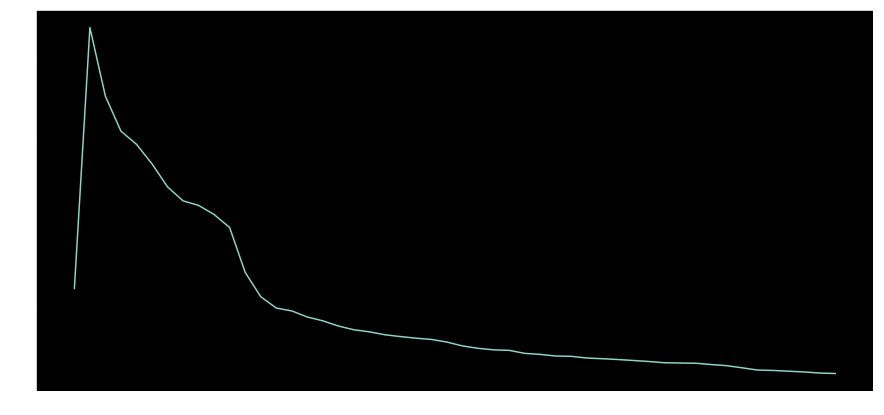

In [70]:
plt.figure(figsize=(15,7))
pd.Series(explained_var).plot()
plt.xticks(range(1,n_components))
plt.show()

Around 12 components would work for characters.

Features: 
* Title length
* TFIDF or Count of the text (use 2 or 3 NGram)
* Auto encoded value / or SVD of the text (approx 10 components for both title words and title chars)
* Number/ratio of uppercase characters
* Title and item reflect each others (use starspace)

### Looking at Description
The work here is very similar than for titles.

One of the particularity of this is that there are no examples in the test set where the description is missing. 

In [71]:
train['description']=train['description'].astype('str') #Put NaNs as 'NaN's

In [72]:
wordVectDesc = CountVectorizer()
desc_sparse = wordVectDesc.fit_transform(train['description'])
print(len(wordVectDesc.vocabulary_))

613423


In [73]:
word_counts = desc_sparse.sum(axis=1)

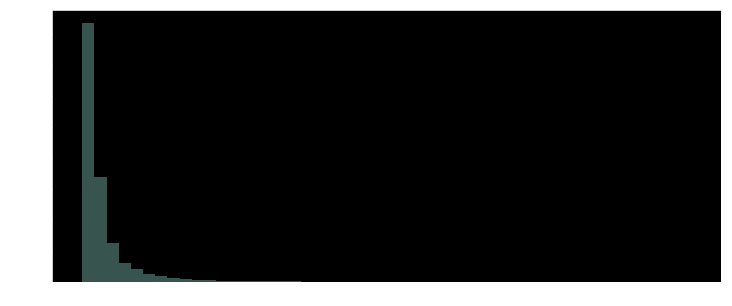

In [74]:
plt.figure(figsize=(12,5))
sns.distplot(word_counts,kde=False)
plt.show()

Some descriptions are very long. Can use the word count as a feature and also its log.

In [75]:
wordVectDesc = TfidfVectorizer(min_df=2,max_df=0.2,ngram_range=(1,2)) #Remove some of the words that are in more 20% of ads. Also remove words and ngrams that are very rare
desc_sparse = wordVectDesc.fit_transform(train['description'])

In [76]:
print(len(wordVectDesc.vocabulary_))

2557108


In [77]:
n_components = 50
svd_desc = TruncatedSVD(n_components=n_components)
desc_sparse_proj  = svd_desc.fit_transform(desc_sparse)

In [78]:
explained_var = explained_variance(desc_sparse_proj,desc_sparse)

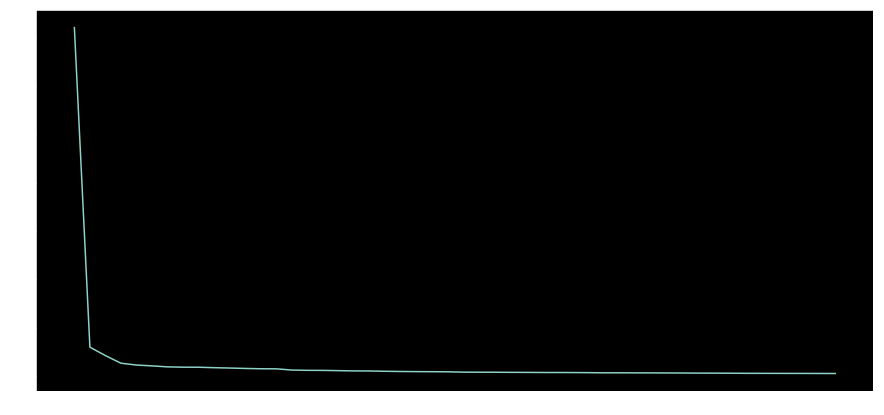

In [79]:
plt.figure(figsize=(15,7))
pd.Series(explained_var).plot()
plt.xticks(range(1,n_components))
plt.show()

The nans probably end up in the first component. Let's plot with a removal of the first component.

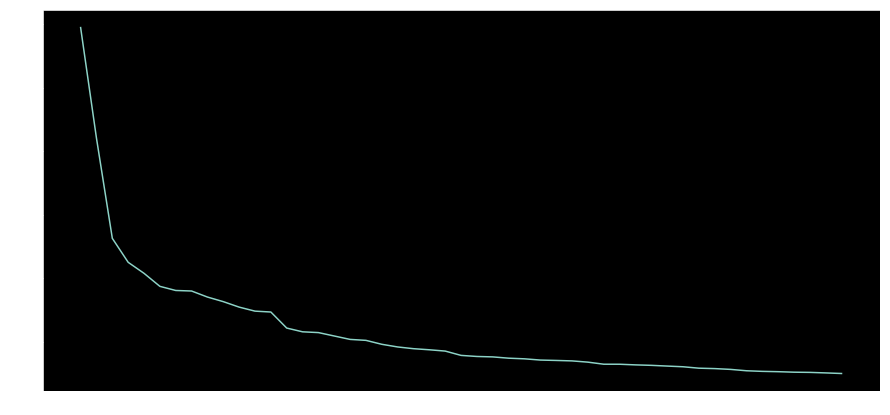

In [80]:
plt.figure(figsize=(15,7))
pd.Series(explained_var[1:]).plot()
plt.xticks(range(2,n_components))
plt.show()

Elbows are at 5, 13, 24, 33 components.

Features :
* Desc Length (+log)
* Try removing examples without description (to match the test set better)
* Use TFIDF with 5, 13, 24, 33 components
* Use starspace to link text with Avido picture classification. Maybe mismatches indicate poor quality of text or image

### List of features based on train.csv only:
* Use the relative_count to put user into a bin depending on size in the dataset.
* Use the count to put city into a bin depending on number of items.
* mean / std / min / max encoding of category (make sure to use a CV scheme to avoid leakage)
* mean / std / min / max encoding of parent category (make sure to use a CV scheme to avoid leakage)
* Log Price
* item_seq_number as numerical
* log item_seq_number
* Use the Category vs Image_top heatmap as a feature. The created variable will have a high number if category is usually associated with that class, and low otherwise. Need to normalize.
    * This can be viewed as a measure of image quality
* Since AVITO is probably classifying the images we could actually try to reverse engineer that model and get the top 1 top 2 top 3 top 4 top 5 instead of only top 1.
    * Using top 5 probability can also give some measure of image quality: high probability probably mean clear distinguishable object
* Some additional stats on category and class relationships (number of classes, average value in normalize matrix etc)
* Treat Params as categories
* For never seen Params see if images can be leveraged to find something resembling (maybe some kind of KNN on images embeddings)
* Title length
* TFIDF or Count of the text (use 2 or 3 NGram)
* Auto encoded value / or SVD of the text (approx 10 components for both title words and title chars)
* Number/ratio of uppercase characters
* Title and item reflect each others (use starspace)
* Desc Length (+log)
* Try removing examples without description (to match the test set better)
* Use TFIDF with 5, 13, 24, 33 components
* Use starspace to link text with Avido picture classification. Maybe mismatches indicate poor quality of text or image

## Ideas to try
* NN model with chars
* NN model for all
* LGB
* Make LGB with sparse TFIDF or BoW. Use best features in Catboost out of the BoW.
* Make a parameter search randomly, store everything then use an algorithm to evaluate the best (make predictions on non evaluated examples).
* Try to predict on every Fold and average out
* LDA Probabilities on text
* Starspace on classification (bin the target)